In [1]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
from openfermion import InteractionOperator, get_fermion_operator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator
from itertools import product
from pennylane.qchem import hf_state, excitations
from pyscf import gto, scf, mcscf
from pyscf.fci.direct_spin1 import FCI as SpinAdaptedFCI
import matplotlib.pyplot as plt
from pathlib import Path
import scipy
from pyscf.fci import cistring
from pyscf import fci

from math import comb


def parity_from_occ(occ):
    """Return permutation parity (+1 or -1) from occupation string when sorting by spin label."""
    # Step 1: Convert to spin labels
    labels = [1 if i % 2 == 0 else 2 for i, o in enumerate(occ) if o == 1]
    
    # Step 2: Compute parity when sorting
    target = sorted(labels)
    perm = []
    used = set()
    for t in target:
        for i, o in enumerate(labels):
            if o == t and i not in used:
                perm.append(i)
                used.add(i)
                break
    parity = 1
    for i in range(len(perm)):
        for j in range(i + 1, len(perm)):
            if perm[i] > perm[j]:
                parity *= -1
    return parity


def build_qubit_state_from_ci(ci, n_orb, nelec):
    n_alpha = nelec // 2
    n_beta = nelec // 2
    assert n_alpha == n_beta, "This function assumes equal number of alpha and beta electrons"
    dim_alpha = int(comb(n_orb, n_alpha))
    dim_beta = int(comb(n_orb, n_beta))
    assert ci.shape == (dim_alpha, dim_beta)

    # Generate all occupation strings
    #alpha_strs = list(combinations(range(n_orb), n_alpha))
    #beta_strs = list(combinations(range(n_orb), n_beta))
    result = []
    for n in cistring.make_strings(range(n_orb), n_alpha):
        # Convert from binary string to integer, then to bit positions
        nb = int(bin(n),2)
        ones_pos = tuple(i for i in range(nb.bit_length()) if (n >> i) & 1)
        result.append(ones_pos)

    alpha_strs = result
    beta_strs = result
    
    n_spin_orb = 2 * n_orb
    dim_qubit = 2 ** n_spin_orb
    wf_qubit = np.zeros(dim_qubit, dtype=ci.dtype)

    for i, a_str in enumerate(alpha_strs):
        for j, b_str in enumerate(beta_strs):
            occ = [0] * n_spin_orb
            for p in a_str:
                occ[2*p] = 1       # spin-up (alpha)
            for p in b_str:
                occ[2*p+1] = 1     # spin-down (beta)
            #occ = occ[::-1]
            s = parity_from_occ(occ)
            idx = int("".join(str(b) for b in occ), 2)
            wf_qubit[idx] = s * ci[i, j]
    return wf_qubit

def qubit_state_to_ci(wf_qubit, n_orb, nelec):
    n_alpha = nelec // 2
    n_beta = nelec // 2
    assert n_alpha == n_beta, "This function assumes equal number of alpha and beta electrons"
    dim_alpha = int(comb(n_orb, n_alpha))
    dim_beta = int(comb(n_orb, n_beta))
    
    ci = np.zeros((dim_alpha, dim_beta), dtype=wf_qubit.dtype)

    # Generate all occupation strings
    #alpha_strs = list(combinations(range(n_orb), n_alpha))
    #beta_strs = list(combinations(range(n_orb), n_beta))
    result = []
    for n in cistring.make_strings(range(n_orb), n_alpha):
        # Convert from binary string to integer, then to bit positions
        nb = int(bin(n),2)
        ones_pos = tuple(i for i in range(nb.bit_length()) if (n >> i) & 1)
        result.append(ones_pos)

    alpha_strs = result
    beta_strs = result
    
    n_spin_orb = 2 * n_orb
    
    for i, a_str in enumerate(alpha_strs):
        for j, b_str in enumerate(beta_strs):
            occ = [0] * n_spin_orb
            for p in a_str:
                occ[2*p] = 1
            for p in b_str:
                occ[2*p+1] = 1
            s = parity_from_occ(occ)
            idx = int("".join(str(b) for b in occ), 2)
            ci[i, j] = s * wf_qubit[idx]

    return ci

# Core VQE implementation
def pennylane_vqe(H_const, h1, g2, nele, init_params=None):
    # Integrals
    def add_spin_1bd(m):
        dim = m.shape[0]
        res = np.zeros((2*dim,2*dim))
        for p, q in product(range(dim), repeat=2):
            res[2*p, 2*q] = m[p,q]
            res[2*p+1, 2*q+1] = m[p,q]
        return res

    def add_spin_2bd(g):
        dim = g.shape[0]
        res = np.zeros((2*dim,)*4)
        for p, q, r, s in product(range(dim), repeat=4):
            val = g[p,q,r,s]
            if abs(val) < 1e-12:
                continue
            for σ1, σ2 in product(range(2), repeat=2):
                res[2*p+σ1, 2*q+σ2, 2*r+σ2, 2*s+σ1] = val
        return res / 2.0

    int1_spin = add_spin_1bd(h1)
    g_phys = g2.transpose((0, 2, 3, 1))
    int2_spin = add_spin_2bd(g_phys)

    # fermionic to qubit Hamiltonian
    intop = InteractionOperator(H_const, int1_spin, int2_spin)
    ferm_ham = get_fermion_operator(intop)
    qub_ham = jordan_wigner(ferm_ham)
    n_qubits = max(i for term in qub_ham.terms for i, _ in term) + 1
    Hmat = get_sparse_operator(qub_ham, n_qubits).toarray()
    H = qml.Hermitian(Hmat, wires=range(n_qubits))

    # UCCSD ansatz
    singles, doubles = excitations(nele, n_qubits)
    hf_bits = hf_state(nele, n_qubits)
    n_sing = len(singles)
    n_doub = len(doubles)

    def ansatz(params):
        qml.BasisState(hf_bits, wires=range(n_qubits))
        for θ, ex in zip(params[:n_sing], singles):
            qml.SingleExcitation(θ, wires=ex)
        for θ, ex in zip(params[n_sing:], doubles):
            qml.DoubleExcitation(θ, wires=ex)

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface="autograd")
    def circuit(params):
        ansatz(params)
        return qml.expval(H)

    cost = lambda p: pnp.real(circuit(p))
    n_params = n_sing + n_doub

    # initialise parameters
    if init_params is None:
        #np.random.seed(0)
        #params = pnp.random.normal(0, 0.01, n_params, requires_grad=True)
        params = pnp.zeros(n_params, requires_grad=True)
    else:
        params = pnp.array(init_params, requires_grad=True)

    # Run VQE
    opt = qml.AdamOptimizer(0.05)
    energy = None
    for i in range(200):
        params, energy = opt.step_and_cost(cost, params)
        if i % 50 == 0:
            print(f"  PL-VQE iter {i:3d} → E = {energy:.8f} Ha")

    energy = pnp.real(circuit(params))
    ################################
    ## implementation of ci_vec
    ################################
    #raise NotImplementedError("ci_vec not defined.")
    @qml.qnode(dev, interface="autograd")
    def _state_qnode(params):
        ansatz(params)
        return qml.state()
    
    psi = _state_qnode(params)
    n_spatial = n_qubits // 2
    
    ci_vec = qubit_state_to_ci(psi, n_orb=n_spatial, nelec=nele)
    assert abs(ci_vec.imag).max() < 1e-10, "CI vector has non-zero imaginary part."
    ci_vec = ci_vec.real
    print('data type of ci_vec:', ci_vec.dtype)
    e_cas_from_ci = fci.direct_spin1.energy(h1, g2, ci_vec, n_spatial, (nele//2, nele//2))
    e_cas_from_ci += H_const
    print(f"  FCI energy from CI vector: {e_cas_from_ci:.8f} Ha")
    print(f"  VQE energy: {energy:.8f} Ha")
    #print("Hconst:", H_const)
    #assert abs(e_cas_from_ci - energy) < 1e-6, "FCI energy from CI vector does not match VQE energy."
    print(f"energy difference: {abs(e_cas_from_ci - energy):.8f} Ha")


    return float(energy), params, ci_vec


# PennyLane‐based FCI solver
class PennyLaneSolver:
    def __init__(self, mf):
        self._mf = mf
        self.params = None
        
        # target the singlet ground‐state only
        self.spin = 0
        self.nroots = 1
        self.root = 0
        
        # classical FCI solver for RDM
        self.classical = SpinAdaptedFCI()
        self.classical.spin = self.spin
        self.classical.nroots = self.nroots
        self.classical.root = self.root

    def kernel(self, h1e, g2e, norb, nelec, ci0=None, verbose=0, max_memory=None, ecore=None, **kwargs):
        # run PennyLane VQE for energy & params
        H_const = self._mf.energy_nuc()
        nele = nelec[0] + nelec[1]
        E, p, ci_vec = pennylane_vqe(H_const, h1e, g2e, nele, init_params=self.params)
        self.params = p

        # classical FCI for CI vector & RDM
        #e2, ci_vec = self.classical.kernel(h1e, g2e, norb, nelec, ci0=ci0, verbose=verbose, max_memory=max_memory, ecore=ecore, **kwargs)
        return E, ci_vec

    def make_rdm12(self, ci_vec, ncas, nelecas):
        # 1 and 2-RDM from the classical CI vector.
        return self.classical.make_rdm12(ci_vec, ncas, nelecas)

In [2]:
def perm_orca2pyscf(**kargs):
    mol = gto.M(**kargs)
    mol.verbose = 0
    def direct_sum(A, B):
        if type(A) == str:
            return B
        if type(B) == str:
            return A
        result = np.zeros((A.shape[0] + B.shape[0], A.shape[1] + B.shape[1]))
        result[:A.shape[0], :A.shape[1]] = A
        result[A.shape[0]:, A.shape[1]:] = B
        return result
    
    perm_block = {
        's':np.array([[1]]),
        'p':np.array([
                    [0,1,0],
                    [0,0,1],
                    [1,0,0]]),
        'd':np.array([
                    [0,0,0,0,1],
                    [0,0,1,0,0],
                    [1,0,0,0,0],
                    [0,1,0,0,0],
                    [0,0,0,1,0]]),
        }
    ind = 0
    perm_mat = 'None'
    while ind < len(mol.ao_labels()):
        l_val = mol.ao_labels()[ind][5]
        if l_val == 's':
            ind += 1
        elif l_val == 'p':
            ind += 3
        elif l_val == 'd':
            ind += 5
        else:
            raise TypeError('wrong l value')
        perm_mat = direct_sum(perm_mat,perm_block[l_val])
    return perm_mat


In [3]:
# Helper for VQE optimization
def run_vqe_cas(mol, mo_guess, ncas, nelecas,solver = 'VQE',mode='SCF'):
    mf_init = scf.RHF(mol); mf_init.kernel()
    if mode == 'SCF':
        mc = mcscf.CASSCF(mf_init, ncas=ncas, nelecas=nelecas)
    else:
        mode == "CI"
        mc = mcscf.CASCI(mf_init, ncas=ncas, nelecas=nelecas)
        
    mc.mo_coeff = mo_guess
    if solver == 'VQE':
        mc.fcisolver = PennyLaneSolver(mf_init)
    else:
        assert solver == 'FCI'
    #mc.max_cycle = 1
    #mc.conv_tol_grad = 1.0

    e_tot, e_cas, ci_vec, mo_coeff, mo_energy = mc.kernel()
    if solver == 'FCI':
        mc.fcisolver.params = None
    return e_tot, mc.fcisolver.params, mo_coeff, ci_vec, mc

In [4]:
### test vqe ci
# HF initial guess
d = 2.3
pos = [[0,0,0], [d,0,0], [2*d,0,0], [3*d,0,0]]
elements = ["H", "H", "H", "H"]
atom = [[el, tuple(c)] for el, c in zip(elements, pos)]
mol = gto.M(atom=atom, basis='cc-pVDZ', spin=0, charge=0, verbose=0)
ncas = nelecas = 4

mf_hf = scf.RHF(mol)
mf_hf.kernel()
E_hf, params_hf, hf_orbitals, hf_ci, mc_hf = run_vqe_cas(mol,  mf_hf.mo_coeff, ncas, nelecas)
print(f"HF-initialized VQE-CAS energy: {E_hf:.8f} Ha")

from pyscf import fci

def extract_rdms_ao(mc):
    """
    Extract the 1-RDM and 2-RDM in AO basis from a CASSCF object.

    Args:
        mc: PySCF CASSCF object

    Returns:
        dm1_ao: 1-RDM in AO basis
        dm2_ao: 2-RDM in AO basis (chemist's notation: (pq|rs))
    """
    ci = mc.ci
    ncas = mc.ncas
    nelecas = mc.nelecas
    mo = mc.mo_coeff
    mo_act = mo[:, mc.ncore:mc.ncore+ncas]

    # 1- and 2-RDMs in the active space
    dm1_cas, dm2_cas = fci.direct_spin1.make_rdm12(ci, ncas, nelecas)

    # Transform 1-RDM to AO basis
    dm1_ao = mo_act @ dm1_cas @ mo_act.T

    # Transform 2-RDM to AO basis
    # (pq|rs) = ∑_{ijkl} C_{pi} C_{qj} C_{rk} C_{sl} * dm2_ijkl
    C = mo_act
    dm2_ao = np.einsum('pi,qj,rk,sl,ijkl->pqrs',
                       C, C, C, C, dm2_cas, optimize=True)

    return dm1_ao, dm2_ao

def energy_from_ao_rdm(mol, dm1_ao, dm2_ao):
    """
    Compute total electronic energy from 1-RDM and 2-RDM in AO basis.

    Args:
        mol: PySCF Mole object
        dm1_ao: 1-RDM in AO basis (shape [n_ao, n_ao])
        dm2_ao: 2-RDM in AO basis (shape [n_ao, n_ao, n_ao, n_ao])

    Returns:
        total_energy: float, total electronic energy in Hartree
    """
    # One-electron AO integrals (T + V)
    h1_ao = mol.intor('int1e_kin') + mol.intor('int1e_nuc')

    # Two-electron AO integrals (physicist's notation)
    eri_ao = mol.intor('int2e')  # (μν|λσ)

    # Energy contributions
    e1 = np.einsum('pq,qp->', h1_ao, dm1_ao)  # Tr[h * D]
    e2 = 0.5 * np.einsum('pqrs,pqrs->', eri_ao, dm2_ao)

    return e1 + e2 + mol.energy_nuc()
    

dm1_ao, dm2_ao = extract_rdms_ao(mc_hf)
e_rdm = energy_from_ao_rdm(mol, dm1_ao, dm2_ao)
print("e_rdm",e_rdm)
assert abs(e_rdm - E_hf) < 1e-5, f"Energy mismatch: {e_rdm:.12f} vs {E_hf:.12f}"


  PL-VQE iter   0 → E = -1.77489053 Ha
  PL-VQE iter  50 → E = -1.97157894 Ha
  PL-VQE iter 100 → E = -1.97306324 Ha
  PL-VQE iter 150 → E = -1.97307468 Ha
data type of ci_vec: float64
  FCI energy from CI vector: -1.97307472 Ha
  VQE energy: -1.97307472 Ha
energy difference: 0.00000000 Ha
  PL-VQE iter   0 → E = -2.00094104 Ha
  PL-VQE iter  50 → E = -2.00138980 Ha
  PL-VQE iter 100 → E = -2.00139267 Ha
  PL-VQE iter 150 → E = -2.00139164 Ha
data type of ci_vec: float64
  FCI energy from CI vector: -2.00139259 Ha
  VQE energy: -2.00139259 Ha
energy difference: 0.00000000 Ha
  PL-VQE iter   0 → E = -2.00877864 Ha
  PL-VQE iter  50 → E = -2.00882461 Ha
  PL-VQE iter 100 → E = -2.00883522 Ha
  PL-VQE iter 150 → E = -2.00883529 Ha
data type of ci_vec: float64
  FCI energy from CI vector: -2.00882957 Ha
  VQE energy: -2.00882957 Ha
energy difference: 0.00000000 Ha
  PL-VQE iter   0 → E = -2.00890787 Ha
  PL-VQE iter  50 → E = -2.00891357 Ha
  PL-VQE iter 100 → E = -2.00891641 Ha
  PL-VQE i

In [5]:
d = 2.3
pos = [[0,0,0], [d,0,0], [2*d,0,0], [3*d,0,0]]
elements = ["H", "H", "H", "H"]
atom = [[el, tuple(c)] for el, c in zip(elements, pos)]

# Load projection from 20.json
obs_path = Path("/pscratch/sd/w/whe1/ML-LinearSpace/output_proj_H46/inference_diss_H4/data/H4_hyb_diss/obs/20.json")
obs_data = np.array(scipy.json.load(open(obs_path))) if False else None
# actually use JSON
import json
obs_data = json.load(open(obs_path))
proj = np.array(obs_data["proj"])

# Overlap and permutation
S = gto.M(atom=atom, basis="cc-pVDZ").intor("int1e_ovlp")
sqrtS = scipy.linalg.sqrtm(S).real
perm = perm_orca2pyscf(atom=atom, basis="cc-pVDZ")
proj = perm @ proj @ perm.T

# Build molecule
mol = gto.M(atom=atom, basis='cc-pVDZ', spin=0, charge=0, verbose=0)
ncas, nelecas = 4, 4

# NN initial guess from projection
from numpy.linalg import eigh, inv
eigvals, eigvecs = eigh(proj)
idx = np.argsort(eigvals)[::-1]
sqrtS_inv = inv(sqrtS)
sorted_eigvecs = sqrtS_inv @ eigvecs[:, idx]
#nn_orbitals = sorted_eigvecs




In [6]:
# run classical vqe

# HF initial guess
mf_hf = scf.RHF(mol)
mf_hf.kernel()
fci_E_hf, fci_params_hf, fci_hf_orbitals, fci_hf_ci, mc_hf_ci = run_vqe_cas(mol,  mf_hf.mo_coeff, ncas, nelecas,solver='FCI')
print(f"HF-initialized CI-CAS energy: {fci_E_hf:.8f} Ha")

# run classical vqe
fci_E_nn, fci_params_nn, fci_nn_orbitals, fci_nn_ci, mc_nn_ci = run_vqe_cas(mol,  sorted_eigvecs, ncas, nelecas,solver='FCI')
print(f"HF-initialized CI-CAS energy: {fci_E_nn:.8f} Ha")

HF-initialized CI-CAS energy: -2.01238375 Ha
HF-initialized CI-CAS energy: -2.01238376 Ha


In [7]:
np.linalg.norm(fci_hf_orbitals[:,:4] @ fci_hf_orbitals[:,:4].T - fci_nn_orbitals[:,:4] @ fci_nn_orbitals[:,:4].T)

np.float64(7.310788253632983e-15)

In [8]:
# Run for NN guess
E_nn, params_nn,nn_orbitals, nn_ci, mc_nn  = run_vqe_cas(mol, sorted_eigvecs, ncas, nelecas)
print(f"NN-initialized VQE-CAS energy: {E_nn:.8f} Ha")

  PL-VQE iter   0 → E = -1.74516443 Ha
  PL-VQE iter  50 → E = -2.00919733 Ha
  PL-VQE iter 100 → E = -2.01059003 Ha
  PL-VQE iter 150 → E = -2.01061775 Ha
data type of ci_vec: float64
  FCI energy from CI vector: -2.01061682 Ha
  VQE energy: -2.01061682 Ha
energy difference: 0.00000000 Ha
  PL-VQE iter   0 → E = -2.01064164 Ha
  PL-VQE iter  50 → E = -2.01063134 Ha
  PL-VQE iter 100 → E = -2.01064424 Ha
  PL-VQE iter 150 → E = -2.01064381 Ha
data type of ci_vec: float64
  FCI energy from CI vector: -2.01064441 Ha
  VQE energy: -2.01064441 Ha
energy difference: 0.00000000 Ha
  PL-VQE iter   0 → E = -2.01064460 Ha
  PL-VQE iter  50 → E = -2.01062304 Ha
  PL-VQE iter 100 → E = -2.01064450 Ha
  PL-VQE iter 150 → E = -2.01064464 Ha
data type of ci_vec: float64
  FCI energy from CI vector: -2.01064466 Ha
  VQE energy: -2.01064466 Ha
energy difference: 0.00000000 Ha
  PL-VQE iter   0 → E = -2.01064467 Ha
  PL-VQE iter  50 → E = -2.01063137 Ha
  PL-VQE iter 100 → E = -2.01064448 Ha
  PL-VQE i

In [9]:



# HF initial guess
mf_hf = scf.RHF(mol)
mf_hf.kernel()
E_hf, params_hf, hf_orbitals, hf_ci, mc_hf = run_vqe_cas(mol,  mf_hf.mo_coeff, ncas, nelecas)
print(f"HF-initialized VQE-CAS energy: {E_hf:.8f} Ha")


  PL-VQE iter   0 → E = -1.77489053 Ha
  PL-VQE iter  50 → E = -1.97157894 Ha
  PL-VQE iter 100 → E = -1.97306324 Ha
  PL-VQE iter 150 → E = -1.97307468 Ha
data type of ci_vec: float64
  FCI energy from CI vector: -1.97307472 Ha
  VQE energy: -1.97307472 Ha
energy difference: 0.00000000 Ha
  PL-VQE iter   0 → E = -2.00094104 Ha
  PL-VQE iter  50 → E = -2.00138980 Ha
  PL-VQE iter 100 → E = -2.00139267 Ha
  PL-VQE iter 150 → E = -2.00139164 Ha
data type of ci_vec: float64
  FCI energy from CI vector: -2.00139259 Ha
  VQE energy: -2.00139259 Ha
energy difference: 0.00000000 Ha
  PL-VQE iter   0 → E = -2.00877864 Ha
  PL-VQE iter  50 → E = -2.00882461 Ha
  PL-VQE iter 100 → E = -2.00883522 Ha
  PL-VQE iter 150 → E = -2.00883529 Ha
data type of ci_vec: float64
  FCI energy from CI vector: -2.00882957 Ha
  VQE energy: -2.00882957 Ha
energy difference: 0.00000000 Ha
  PL-VQE iter   0 → E = -2.00890787 Ha
  PL-VQE iter  50 → E = -2.00891357 Ha
  PL-VQE iter 100 → E = -2.00891641 Ha
  PL-VQE i

In [10]:
np.linalg.norm(hf_orbitals[:,:4] @ hf_orbitals[:,:4].T - nn_orbitals[:,:4] @ nn_orbitals[:,:4].T)

np.float64(0.006248051957746277)

In [11]:
# Compute 1-RDM in the active space
rdm1 = mc_hf_ci.fcisolver.make_rdm1(fci_hf_ci, mc_hf_ci.ncas, mc_hf_ci.nelecas)

# Verify trace equals electron number (active electrons)
trace_rdm1 = rdm1.trace()
eigvals = np.linalg.eigvalsh(rdm1)[::-1]  # Hermitian, so eigvalsh is faster
print("Eigenvalues of the active-space 1-RDM:")
print(eigvals)

Eigenvalues of the active-space 1-RDM:
[1.45198025 1.30470114 0.69964422 0.54367439]


In [12]:
# Compute 1-RDM in the active space
rdm1 = mc_nn_ci.fcisolver.make_rdm1(fci_nn_ci, mc_nn_ci.ncas, mc_nn_ci.nelecas)

# Verify trace equals electron number (active electrons)
trace_rdm1 = rdm1.trace()
eigvals = np.linalg.eigvalsh(rdm1)  # Hermitian, so eigvalsh is faster
print("Eigenvalues of the active-space 1-RDM:")
print(eigvals)

Eigenvalues of the active-space 1-RDM:
[0.54369424 0.69957223 1.30478235 1.45195117]


In [13]:
from pyscf import fci
def casscf_overlap(mc1, mc2):
    """
    Compute the overlap between two CASSCF wavefunctions.
    
    Args:
        mc1: PySCF CASSCF object for wavefunction 1
        mc2: PySCF CASSCF object for wavefunction 2
        
    Returns:
        overlap: <Psi1 | Psi2>
        infidelity: 1 - |<Psi1 | Psi2>|^2
    """
    mol = mc1.mol
    assert mc1.ncas == mc2.ncas, "Active space size must match"
    assert mc1.nelecas == mc2.nelecas, "Active electron count must match"
    assert mol == mc2.mol, "Both wavefunctions must share the same molecule (AO basis)"
    
    # Extract CI and MO coefficients
    ci1, ci2 = mc1.ci, mc2.ci
    mo1, mo2 = mc1.mo_coeff, mc2.mo_coeff
    ncas, nelecas = mc1.ncas, mc1.nelecas

    # AO overlap matrix (shared AO basis)
    S_ao = mol.intor('int1e_ovlp')
    
    # MO overlap in active space
    mo1_act = mo1[:, mc1.ncore:mc1.ncore+ncas]
    mo2_act = mo2[:, mc2.ncore:mc2.ncore+ncas]
    S_mo = mo1_act.T @ S_ao @ mo2_act
    
    # CI overlap
    overlap = fci.addons.overlap(ci1, ci2, ncas, nelecas, S_mo)
    infidelity = 1 - abs(overlap)**2
    
    return infidelity
print((nn_ci).shape)
print("Infid(nn-vqe,hf-vqe):", casscf_overlap(mc_hf, mc_nn))
print("Infid(nn-vqe,fci):", casscf_overlap(mc_nn, mc_hf_ci))
print("Infid(hf-vqe,fci):", casscf_overlap(mc_hf, mc_hf_ci))
print("Infid(fci-1,fci-2):", casscf_overlap(mc_nn_ci, mc_hf_ci))

(6, 6)
Infid(nn-vqe,hf-vqe): 0.005161718253940961
Infid(nn-vqe,fci): 0.0028382365800986298
Infid(hf-vqe,fci): 0.009108592997041587
Infid(fci-1,fci-2): 2.574846628133898e-07


In [14]:
import numpy as np
from pyscf import fci

def extract_rdms_ao(mc):
    """
    Extract the 1-RDM and 2-RDM in AO basis from a CASSCF object.

    Args:
        mc: PySCF CASSCF object

    Returns:
        dm1_ao: 1-RDM in AO basis
        dm2_ao: 2-RDM in AO basis (chemist's notation: (pq|rs))
    """
    ci = mc.ci
    ncas = mc.ncas
    nelecas = mc.nelecas
    mo = mc.mo_coeff
    mo_act = mo[:, mc.ncore:mc.ncore+ncas]

    # 1- and 2-RDMs in the active space
    dm1_cas, dm2_cas = fci.direct_spin1.make_rdm12(ci, ncas, nelecas)

    # Transform 1-RDM to AO basis
    dm1_ao = mo_act @ dm1_cas @ mo_act.T

    # Transform 2-RDM to AO basis
    # (pq|rs) = ∑_{ijkl} C_{pi} C_{qj} C_{rk} C_{sl} * dm2_ijkl
    C = mo_act
    dm2_ao = np.einsum('pi,qj,rk,sl,ijkl->pqrs',
                       C, C, C, C, dm2_cas, optimize=True)

    return dm1_ao, dm2_ao


def compare_rdms_ao(mc1, mc2):
    """
    Compare 1-RDM and 2-RDM in AO basis between two CASSCF wavefunctions.

    Args:
        mc1, mc2: PySCF CASSCF objects

    Returns:
        dm1_ao_1, dm1_ao_2, dm2_ao_1, dm2_ao_2
    """
    dm1_ao_1, dm2_ao_1 = extract_rdms_ao(mc1)
    dm1_ao_2, dm2_ao_2 = extract_rdms_ao(mc2)

    # Frobenius norm of difference
    diff_dm1 = np.linalg.norm(dm1_ao_1 - dm1_ao_2)
    diff_dm2 = np.linalg.norm(dm2_ao_1 - dm2_ao_2)

    print("🔬 1-RDM AO difference (Frobenius norm):", diff_dm1)
    print("🔬 2-RDM AO difference (Frobenius norm):", diff_dm2)

    return dm1_ao_1, dm1_ao_2, dm2_ao_1, dm2_ao_2


dm1_ao_nn, dm1_ao_hf, dm2_ao_nn, dm2_ao_hf = compare_rdms_ao(mc_nn, mc_hf)


🔬 1-RDM AO difference (Frobenius norm): 0.02541588975602765
🔬 2-RDM AO difference (Frobenius norm): 0.12661907799040015


In [15]:
def energy_from_ao_rdm(mol, dm1_ao, dm2_ao):
    """
    Compute total electronic energy from 1-RDM and 2-RDM in AO basis.

    Args:
        mol: PySCF Mole object
        dm1_ao: 1-RDM in AO basis (shape [n_ao, n_ao])
        dm2_ao: 2-RDM in AO basis (shape [n_ao, n_ao, n_ao, n_ao])

    Returns:
        total_energy: float, total electronic energy in Hartree
    """
    # One-electron AO integrals (T + V)
    h1_ao = mol.intor('int1e_kin') + mol.intor('int1e_nuc')

    # Two-electron AO integrals (physicist's notation)
    eri_ao = mol.intor('int2e')  # (μν|λσ)

    # Energy contributions
    e1 = np.einsum('pq,qp->', h1_ao, dm1_ao)  # Tr[h * D]
    e2 = 0.5 * np.einsum('pqrs,pqrs->', eri_ao, dm2_ao)

    return e1 + e2 + mol.energy_nuc()
    
e_nn = energy_from_ao_rdm(mol, dm1_ao_nn, dm2_ao_nn)
e_hf = energy_from_ao_rdm(mol, dm1_ao_hf, dm2_ao_hf)

print(f"Energy from NN-init RDMs: {e_nn:.12f} Ha")
print(f"Energy from HF-init RDMs: {e_hf:.12f} Ha")
print(f"ΔE = {e_nn - e_hf:.6e} Ha")

Energy from NN-init RDMs: -2.010644673498 Ha
Energy from HF-init RDMs: -2.008869017437 Ha
ΔE = -1.775656e-03 Ha


In [16]:
# Extract active space integrals
def get_active_space_integrals(mol, mo_coeff, ncas, nelecas):
    # Get AO integrals
    h_ao = mol.intor('int1e_kin') + mol.intor('int1e_nuc')
    eri_ao = mol.intor('int2e')
    
    # Extract active space MOs (assuming they are the first ncas orbitals)
    mo_cas = mo_coeff[:, :ncas]
    
    # Transform to active space
    h1e = mo_cas.T @ h_ao @ mo_cas
    
    # Two-electron integrals in chemist notation (11|22)
    g2e = np.einsum('pqrs,pi,qj,rk,sl->ijkl', eri_ao, mo_cas, mo_cas, mo_cas, mo_cas)
    
    return h1e, g2e


# Orthogonalize MO coefficients with respect to overlap matrix S
def orthogonalize_mo_gram_schmidt(mo, S):
    n_aos, n_mos = mo.shape
    mo_orth = mo.copy()
    
    for i in range(n_mos):
        # Normalize
        norm = np.sqrt(mo_orth[:, i].T @ S @ mo_orth[:, i])
        mo_orth[:, i] /= norm
        
        # Orthogonalize against previous vectors
        for j in range(i+1, n_mos):
            overlap = mo_orth[:, i].T @ S @ mo_orth[:, j]
            mo_orth[:, j] -= overlap * mo_orth[:, i]
    
    return mo_orth


# Orbital interpolation using Cayley transform
def interpolate_mo_cayley(mo1, mo2, t, S=None):
    if t == 0.0:
        return mo1.copy()
    elif t == 1.0:
        return mo2.copy()
    
    # Compute rotation matrix
    if S is not None:
        R = mo1.T @ S @ mo2
    else:
        R = mo1.T @ mo2
    
    I = np.eye(R.shape[0])
    

    # Fallback to eigenvalue interpolation
    eigvals, eigvecs = np.linalg.eig(R)
    angles = np.angle(eigvals)
    angles_t = t * angles
    R_t = np.real(eigvecs @ np.diag(np.exp(1j * angles_t)) @ eigvecs.conj().T)
    
    # Apply rotation
    mo_t = mo1 @ R_t
    
    # Ensure orthonormality
    if S is not None:
        mo_t = orthogonalize_mo_gram_schmidt(mo_t, S)
    else:
        Q, _ = np.linalg.qr(mo_t)
        mo_t = Q
    
    return mo_t


# Single-shot VQE evaluation
def run_casscf_with_guess(mol, mo_guess, ncas, nelecas, label="", solver='VQE', vqe_params=None):
    if solver.upper() != 'VQE':
        raise ValueError("Only VQE solver is supported in this clean version")
    
    if vqe_params is None:
        raise ValueError("vqe_params must be provided for VQE")
    
    # Get active space integrals
    h1e, g2e = get_active_space_integrals(mol, mo_guess, ncas, nelecas)
    H_const = mol.energy_nuc()
    
    # Handle nelecas
    if isinstance(nelecas, (tuple, list)):
        n_electrons = sum(nelecas)
    else:
        n_electrons = nelecas
    
    # Single-shot evaluation
    from itertools import product
    
    # Add spin
    def add_spin_1bd(m):
        dim = m.shape[0]
        res = np.zeros((2*dim,2*dim))
        for p, q in product(range(dim), repeat=2):
            res[2*p, 2*q] = m[p,q]
            res[2*p+1, 2*q+1] = m[p,q]
        return res

    def add_spin_2bd(g):
        dim = g.shape[0]
        res = np.zeros((2*dim,)*4)
        for p, q, r, s in product(range(dim), repeat=4):
            val = g[p,q,r,s]
            if abs(val) < 1e-12:
                continue
            for σ1, σ2 in product(range(2), repeat=2):
                res[2*p+σ1, 2*q+σ2, 2*r+σ2, 2*s+σ1] = val
        return res / 2.0

    int1_spin = add_spin_1bd(h1e)
    g_phys = g2e.transpose((0, 2, 3, 1))
    int2_spin = add_spin_2bd(g_phys)

    # Build Hamiltonian
    intop = InteractionOperator(H_const, int1_spin, int2_spin)
    ferm_ham = get_fermion_operator(intop)
    qub_ham = jordan_wigner(ferm_ham)
    n_qubits = max(i for term in qub_ham.terms for i, _ in term) + 1
    Hmat = get_sparse_operator(qub_ham, n_qubits).toarray()
    H = qml.Hermitian(Hmat, wires=range(n_qubits))

    # Build ansatz
    singles, doubles = excitations(n_electrons, n_qubits)
    hf_bits = hf_state(n_electrons, n_qubits)
    n_sing = len(singles)

    def ansatz(params):
        qml.BasisState(hf_bits, wires=range(n_qubits))
        for θ, ex in zip(params[:n_sing], singles):
            qml.SingleExcitation(θ, wires=ex)
        for θ, ex in zip(params[n_sing:], doubles):
            qml.DoubleExcitation(θ, wires=ex)

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface="autograd")
    def circuit(params):
        ansatz(params)
        return qml.expval(H)

    # Single evaluation
    params = pnp.array(vqe_params, requires_grad=False)
    energy = float(pnp.real(circuit(params)))
    
    print(f"Single-shot VQE ({label}) energy: {energy:.8f} Ha")
    return None, 0, mo_guess, energy


# Main scanning function
def extended_vqe_optimization_scan(mol, mo1, mo2, params1, params2, ncas, nelecas, t_min=-0.3, t_max=1.3, n_points=21):
    S = mol.intor("int1e_ovlp")
    ts = np.linspace(t_min, t_max, n_points)
    
    energies_opt = []
    params_opt = []
    converged = []
    
    print(f"\n=== Extended VQE Optimization Scan [{t_min}, {t_max}] ===")
    print("Optimizing VQE at each interpolation point...")
    print("\nt       Energy (Ha)    Status")
    print("-" * 40)
    
    for i, t in enumerate(ts):
        # Interpolate orbitals
        mo_t = interpolate_mo_cayley(mo1, mo2, t, S)
        #mo_t = mo1

        params_init = (1 - t) * params1 + t * params2
        #params_init = params1
        # Initial guess for parameters
        #if t < 0:
        #    params_init = (1 - 2*abs(t)) * params1 + 2*abs(t) * np.zeros_like(params1)
        #elif t > 1:
        #    params_init = (2 - t) * params2 + (t - 1) * np.zeros_like(params2)
        #else:
        #    params_init = (1 - t) * params1 + t * params2
        
        print(f"\nOptimizing at t={t:.4f}...")
        
        #try:
            # Full VQE optimization
        #e_tot, params_final, _, _, _ = run_vqe_cas(mol, mo_t, ncas, nelecas,mode='CI')
        #    energies_opt.append(e_tot)
        #    params_opt.append(params_final)
        #    converged.append(True)
        #    status = "Converged"
        #except Exception as e:
        #    print(f"  Warning: Optimization failed at t={t:.2f}: {str(e)}")
            # Use single-shot energy with interpolated params as fallback
        _, _, _, e_tot = run_casscf_with_guess(
            mol, mo_t, ncas, nelecas,
            solver='VQE', vqe_params=params_init
        )
        energies_opt.append(e_tot)
        #    params_opt.append(params_init)
        converged.append(True)
        #    status = "Failed"
        
        #print(f"{t:5.2f}   {energies_opt[-1]:12.8f}   {status}")
    
    return ts, np.array(energies_opt), params_opt, converged

# Run scan from -0.3 to 1.3

ts_ext, E_opt_ext, params_opt_ext, converged_ext = extended_vqe_optimization_scan(
    mol, hf_orbitals, nn_orbitals, params_hf, params_nn,
    ncas, nelecas, t_min=-0.2, t_max=1.2, n_points=29
)



=== Extended VQE Optimization Scan [-0.2, 1.2] ===
Optimizing VQE at each interpolation point...

t       Energy (Ha)    Status
----------------------------------------

Optimizing at t=-0.2000...
Single-shot VQE () energy: -1.14848226 Ha

Optimizing at t=-0.1500...
Single-shot VQE () energy: -1.48973996 Ha

Optimizing at t=-0.1000...
Single-shot VQE () energy: -1.76593225 Ha

Optimizing at t=-0.0500...
Single-shot VQE () energy: -1.94613065 Ha

Optimizing at t=-0.0000...
Single-shot VQE () energy: -2.00886902 Ha

Optimizing at t=0.0500...
Single-shot VQE () energy: -1.94577472 Ha

Optimizing at t=0.1000...
Single-shot VQE () energy: -1.76330325 Ha

Optimizing at t=0.1500...
Single-shot VQE () energy: -1.48205447 Ha

Optimizing at t=0.2000...
Single-shot VQE () energy: -1.13375633 Ha

Optimizing at t=0.2500...
Single-shot VQE () energy: -0.75659350 Ha

Optimizing at t=0.3000...
Single-shot VQE () energy: -0.38993686 Ha

Optimizing at t=0.3500...
Single-shot VQE () energy: -0.06957557 


=== Extended Scan Analysis ===
Global minimum: -2.01064467 Ha at t=1.00
Global maximum: 0.37075499 Ha at t=0.50
Barrier height: 1494.35 kcal/mol


/tmp/ipykernel_1891383/1786660137.py:78: UserWarning: Unknown infodict keyword: 'TextAsShapes'. Must be one of {'CreationDate', 'ModDate', 'Trapped', 'Creator', 'Subject', 'Author', 'Producer', 'Title', 'Keywords'}.
  plt.savefig('figs/double_well.pdf', metadata={"TextAsShapes": False})


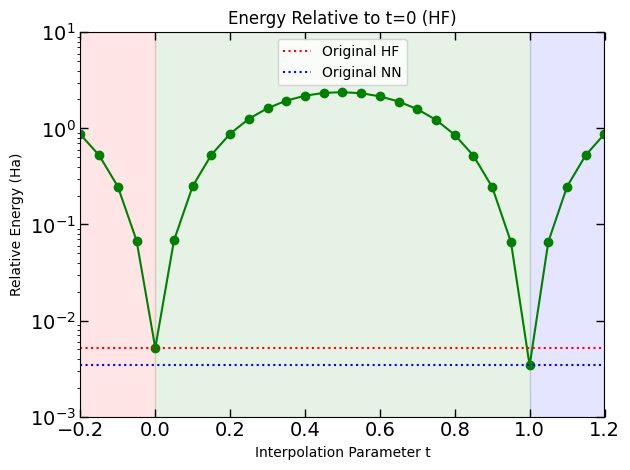

In [17]:

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

# Visualization function
def visualize_extended_scan(ts, energies, converged, E_hf_orig, E_nn_orig):
    energies = np.array(energies)
    converged = np.array(converged)

    # Derive t_min and t_max from the data itself
    t_min = float(ts.min())
    t_max = float(ts.max())

    # Key indices
    idx_min = np.argmin(energies)
    idx_max = np.argmax(energies)

    print("\n=== Extended Scan Analysis ===")
    print(f"Global minimum: {energies[idx_min]:.8f} Ha at t={ts[idx_min]:.2f}")
    print(f"Global maximum: {energies[idx_max]:.8f} Ha at t={ts[idx_max]:.2f}")
    barrier = (energies[idx_max] - energies[idx_min]) * 627.509
    print(f"Barrier height: {barrier:.2f} kcal/mol")
    '''
    # ==========================
    # Figure 1: Energy Surface
    # ==========================
    plt.figure(figsize=(10, 5))
    plt.plot(ts[converged], energies[converged], 'go-', label='Optimized VQE')
    if np.any(~converged):
        plt.plot(ts[~converged], energies[~converged], 'rx', label='Failed optimization')

    # Highlight regions
    plt.axvspan(t_min, 0, color='blue', alpha=0.1, label='HF extrapolation')
    plt.axvspan(0, 1, color='green', alpha=0.1, label='Interpolation region')
    plt.axvspan(1, t_max, color='red', alpha=0.1, label='NN extrapolation')

    # Reference lines
    plt.axhline(E_hf_orig, color='blue', linestyle=':', label='Original HF')
    plt.axhline(E_nn_orig, color='red', linestyle=':', label='Original NN')
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(1, color='gray', linestyle='--', alpha=0.5)

    plt.ylabel('Energy (Ha)')
    plt.xlabel('Interpolation Parameter t')
    plt.title('Extended VQE Energy Surface')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    '''
    # ==========================
    # Figure 2: Relative Energy (kcal/mol)
    # ==========================
    print("Warning: set E_ref manually")
    E_ref = -2.0140511195198982
    rel = (energies - E_ref) 

    # plt.figure(figsize=(10, 8))
    plt.figure()
    plt.plot(ts[converged], rel[converged], 'go-')
    plt.axhline(0, color='black', linestyle='-', alpha=0.3)
    plt.axvspan(t_min, 0, color='red', alpha=0.1)
    plt.axvspan(0, 1, color='green', alpha=0.1)
    plt.axvspan(1, t_max, color='blue', alpha=0.1)
    plt.tick_params(axis='both', direction='in',which='major', length=6, width=1, labelsize=14, top=True, right=True)
    plt.yscale('log')
    plt.xlim(-0.2, 1.2)
    plt.ylim(1e-3, 1e1)
    plt.axhline((E_hf_orig - E_ref), color='red', linestyle=':', label='Original HF')
    plt.axhline((E_nn_orig - E_ref) , color='blue', linestyle=':', label='Original NN')

    plt.xlabel('Interpolation Parameter t')
    plt.ylabel('Relative Energy (Ha)')
    plt.title('Energy Relative to t=0 (HF)')
    #plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    #plt.show()
    plt.savefig('figs/double_well.pdf', metadata={"TextAsShapes": False})
    
    return idx_min, idx_max

# Visualize results
idx_min, idx_max = visualize_extended_scan(ts_ext, E_opt_ext, converged_ext, E_hf, E_nn)

# Save results for further analysis
results = {
    't': ts_ext,
    'energy': E_opt_ext,
    'converged': converged_ext,
    'params': params_opt_ext,
    'E_hf_original': E_hf,
    'E_nn_original': E_nn
}